# Churn analysis using data from Telcom Customer Churn [IBM Sample Data Sets]

##  Data source: https://www.kaggle.com/blastchar/telco-customer-churn

In [107]:
#!pip install lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#pip install tabulate

#!pip install lifelines
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split

#!pip install pysurvival
#from pysurvival.models.survival_forest import RandomSurvivalForestModel
#from pysurvival.utils.metrics import concordance_index

from sksurv.ensemble import RandomSurvivalForest

#!pip install pycox
import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [108]:
churn_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')


In [109]:
churn_data.head(5)
#print(churn_data.head(5))
print(pd.DataFrame.to_markdown(churn_data.head(5)))

|    | customerID   | gender   |   SeniorCitizen | Partner   | Dependents   |   tenure | PhoneService   | MultipleLines    | InternetService   | OnlineSecurity   | OnlineBackup   | DeviceProtection   | TechSupport   | StreamingTV   | StreamingMovies   | Contract       | PaperlessBilling   | PaymentMethod             |   MonthlyCharges |   TotalCharges | Churn   |
|---:|:-------------|:---------|----------------:|:----------|:-------------|---------:|:---------------|:-----------------|:------------------|:-----------------|:---------------|:-------------------|:--------------|:--------------|:------------------|:---------------|:-------------------|:--------------------------|-----------------:|---------------:|:--------|
|  0 | 7590-VHVEG   | Female   |               0 | Yes       | No           |        1 | No             | No phone service | DSL               | No               | Yes            | No                 | No            | No            | No                | Month-to-month

In [110]:
churn_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Let's denote T the time that a client has been with the company and E the event variable indicating whether or not the customer left the company. And let’s look at the survival rate for the average customer using a Kaplan-Meier (KM) survival curve

In [119]:
T = churn_data["tenure"].astype(float)
E = np.where(churn_data["Churn"]=='Yes',1,0)

Text(0.5, 1.0, 'Survival function all customers')

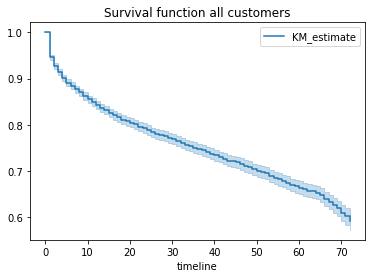

In [112]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
#kmf.survival_function_.plot()
kmf.plot_survival_function() #include confidence interval
plt.title('Survival function all customers')


## For example, the figure shows that after 10 months, the chance that a customer remains as a client is around 85% and after 2 years the company is able to retain more than 75% of the customers.

## Now, let’s segment this curve by different contracts

Text(0.5, 1.0, 'Lifespans of different contracts')

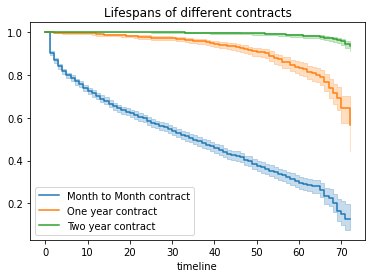

In [113]:
np.unique( churn_data['Contract'].values)
#takes on month to month, one year and two year contract
month_to_month = (churn_data['Contract']=='Month-to-month')
one_y = (churn_data['Contract']=='One year')
two_y = (churn_data['Contract']=='Two year')

ax = plt.subplot(111)
kmf.fit(T[month_to_month], event_observed=E[month_to_month], label="Month to Month contract")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[one_y], event_observed=E[one_y], label="One year contract")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[two_y], event_observed=E[two_y], label="Two year contract")
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different contracts")

# the churn is driven by the month-to-month contracts. So the company should focus on those customer implementing policies in order to retain them

## The previous figure shows that the churn rate is driven by the month-to-month contracts. So the company should focus on those customers implementing policies in order to retain them.

## Even though the difference between survival functions is very obvious, let' s do it formally using a statistical test: the log-rank test

In [116]:

from lifelines.statistics import logrank_test

results = logrank_test(T[month_to_month], T[one_y], E[month_to_month], E[one_y], alpha=.99)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         926.06 <0.005    673.27

## To examine the effects of different features such as type of contracts, socio demographics characteristics, etc. I will use the Cox Proportional Hazards model.

## First, I need to encode categorical variables into binary variables.

In [117]:
churn_data_dummies = churn_data[['gender', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']]

data_with_dummies = pd.get_dummies(churn_data_dummies,columns= ['gender', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'],drop_first=False,dtype=float)

d = {
 "E": pd.Series(E),
 "T": pd.Series(T),
   }
data_cox = pd.concat([pd.DataFrame(d).astype(float),pd.DataFrame(churn_data[['SeniorCitizen','MonthlyCharges']]),data_with_dummies], axis=1)

In [121]:
from lifelines import CoxPHFitter

# Cox regression applied to all variable faces a convergence problem
cph = CoxPHFitter()
cph.fit(data_cox, duration_col='T', event_col='E')
# this throws an error due to convergence problem

## The previous model throws an error due to convergence problem. One solution is to select a subset of features. Instead of doing that and because we want to use all features, I carry out a Cox regression posing a penalization term. 

In [122]:
# Cox regression with penalization term (this method performs variable selection)
cph = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # sparse solutions
cph.fit(data_cox, duration_col='T', event_col='E')
cph.print_summary()
print(pd.DataFrame.to_markdown(cph.print_summary()))

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15186.90
         time fit was run = 2021-05-09 21:38:46 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                       
SeniorCitizen                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MonthlyCharges                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender_Female                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender_Male                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Partner_No                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Partner_Yes                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Dependents_No                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Dependents_Yes                           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PhoneService_No                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PhoneService_Yes                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MultipleLines_No                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MultipleLines_No phone service           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MultipleLines_Yes                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
InternetService_DSL                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
InternetService_Fiber optic               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
InternetService_No                       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineSecurity_No                         0.18       1.20       0.05             0.07             0.28                 1.08                 1.33
OnlineSecurity_No internet service       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineSecurity_Yes                       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineBackup_No                           0.12       1.12       0.05             0.02             0.21                 1.02                 1.24
OnlineBackup_No internet service         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineBackup_Yes                         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
DeviceProtection_No                       0.00       1.00       0.00            -0.00             0.

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15186.90
         time fit was run = 2021-05-09 21:38:46 UTC

---
                                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                       
SeniorCitizen                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MonthlyCharges                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender_Female                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender_Male                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Partner_No                                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Partner_Yes                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Dependents_No                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Dependents_Yes                           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PhoneService_No                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PhoneService_Yes                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MultipleLines_No                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MultipleLines_No phone service           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MultipleLines_Yes                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
InternetService_DSL                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
InternetService_Fiber optic               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
InternetService_No                       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineSecurity_No                         0.18       1.20       0.05             0.07             0.28                 1.08                 1.33
OnlineSecurity_No internet service       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineSecurity_Yes                       -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineBackup_No                           0.12       1.12       0.05             0.02             0.21                 1.02                 1.24
OnlineBackup_No internet service         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
OnlineBackup_Yes                         -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
DeviceProtection_No                       0.00       1.00       0.00            -0.00             0.

## The following plot shows that the customers that are more likely to cancel their service are those that have month-to-month 's contracts; no extra services like online security, online backup and technical services. Nevertheless, the churn rate seem to be driven by the type of contract, the montly contracts.

<AxesSubplot:title={'center':'Survival Regression: Coefficients and Confident Intervals'}, xlabel='log(HR) (95% CI)'>

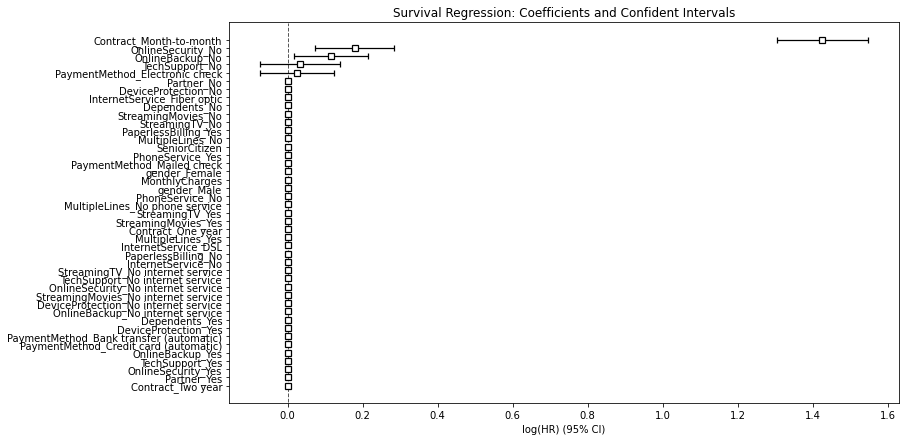

In [123]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef)


## Now let 's apply another type of model: random forest where the split criteria is based on the log-rank test. I fit a Random Survival Forest using 100 trees. We split the data into training (75% ) and test (25%) so we can determine how well our model is able to generalize

In [124]:
#from sksurv.ensemble import RandomSurvivalForest
#or !pip install pysurvival

from sklearn.model_selection import train_test_split
random_state = 20
Xt = data_cox.iloc[:,2:]
y = data_cox.iloc[:,:2]
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

# Building the model
rsf = RandomSurvivalForest(n_estimators=100,min_samples_split=10, min_samples_leaf=15,max_features="sqrt",n_jobs=-1,random_state=random_state)
# .fit() requires that the event, time be a structured array and for that we use the function Surv from util
from sksurv.util import Surv
y_surv_train = Surv.from_arrays(event=y_train.iloc[:,0], time=y_train.iloc[:,1]) 
rsf.fit(X_train, np.array(y_surv_train))



RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_jobs=-1, random_state=20)

## We check the performance of the model by evaluating it on the test data. The ensemble prediction is simply the average across all trees in the forest.

In [125]:
y_surv_test = Surv.from_arrays(event=y_test.iloc[:,0], time=y_test.iloc[:,1]) 
print('concordance index') 
rsf.score(X_test, y_surv_test)


concordance index


0.8580356883426313

## The following boxplot shows the predicted risk and it is helpful to indentify clients above certain threshold. For example, the clients that have a predicted risk above 60. The same customers are those with monthly contract and no extra services  as well as  no dependents

{'whiskers': [<matplotlib.lines.Line2D at 0x1842b439320>,
 'caps': [<matplotlib.lines.Line2D at 0x1842b4399b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1842b4394e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1842b439080>],
 'fliers': [<matplotlib.lines.Line2D at 0x1842b4a91d0>],
 'means': []}

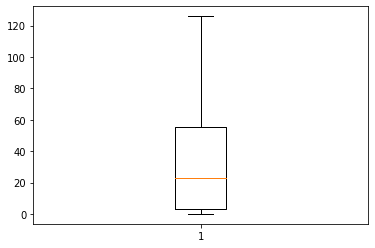

In [34]:
score_pred = pd.Series(rsf.predict(X_test))
plt.boxplot(score_pred)


In [103]:
print(pd.DataFrame.to_markdown(X_test.iloc[(score_pred>=60).values,:].describe()))


|       |   SeniorCitizen |   MonthlyCharges |   gender_Female |   gender_Male |   Partner_No |   Partner_Yes |   Dependents_No |   Dependents_Yes |   PhoneService_No |   PhoneService_Yes |   MultipleLines_No |   MultipleLines_No phone service |   MultipleLines_Yes |   InternetService_DSL |   InternetService_Fiber optic |   InternetService_No |   OnlineSecurity_No |   OnlineSecurity_No internet service |   OnlineSecurity_Yes |   OnlineBackup_No |   OnlineBackup_No internet service |   OnlineBackup_Yes |   DeviceProtection_No |   DeviceProtection_No internet service |   DeviceProtection_Yes |   TechSupport_No |   TechSupport_No internet service |   TechSupport_Yes |   StreamingTV_No |   StreamingTV_No internet service |   StreamingTV_Yes |   StreamingMovies_No |   StreamingMovies_No internet service |   StreamingMovies_Yes |   Contract_Month-to-month |   Contract_One year |   Contract_Two year |   PaperlessBilling_No |   PaperlessBilling_Yes |   PaymentMethod_Bank transfer (automatic) |

## Now, I fit a deep neural network. The conclusions are the same. For instance, the customers that are more likely to leave the company in the first year are those that their contract is monthly, they do not have dependents and they do not have other extra services with the company

In [126]:
# Deep Neural Network

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
#standarize continuous features and leaves the binary ones as is
cols_standardize = ['SeniorCitizen','MonthlyCharges']
cols_leave = X_train.columns[~X_train.columns.isin(['SeniorCitizen','MonthlyCharges'])]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(X_train)


In [85]:
#we split the training data set into train and validation
x_train, x_val, e_t_train, e_t_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

x_train = x_mapper.fit_transform(x_train).astype('float32')
x_val = x_mapper.transform(x_val).astype('float32')
x_test = x_mapper.transform(X_test).astype('float32')


In [86]:
in_features = x_train.shape[1]
num_nodes = [8, 4]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)


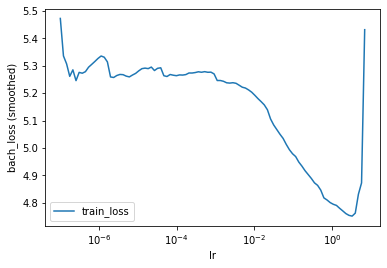

In [89]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(x_train, (np.array(e_t_train.iloc[:,1].astype('float32')),np.array(e_t_train.iloc[:,0].astype('float32'))), batch_size, tolerance=10)
_ = lrfinder.plot()

In [90]:
lrfinder.get_best_lr()

0.32745491628777507

In [92]:
val = x_val, (np.array(e_t_val.iloc[:,1].astype('float32')),np.array(e_t_val.iloc[:,0].astype('float32')))
model.optimizer.set_lr(0.1)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, (np.array(e_t_train.iloc[:,1].astype('float32')),np.array(e_t_train.iloc[:,0].astype('float32'))), batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.1218,	val_loss: 3.8340
1:	[0s / 0s],		train_loss: 4.1741,	val_loss: 3.8366
2:	[0s / 0s],		train_loss: 4.1017,	val_loss: 3.8683
3:	[0s / 0s],		train_loss: 4.0756,	val_loss: 3.9130
4:	[0s / 1s],		train_loss: 4.0615,	val_loss: 3.8748
5:	[0s / 1s],		train_loss: 4.0613,	val_loss: 3.8235
6:	[0s / 1s],		train_loss: 4.0423,	val_loss: 3.8653
7:	[0s / 1s],		train_loss: 4.0483,	val_loss: 3.8706
8:	[0s / 2s],		train_loss: 4.0614,	val_loss: 3.8232
9:	[0s / 2s],		train_loss: 4.0401,	val_loss: 4.0438
10:	[0s / 2s],		train_loss: 4.0306,	val_loss: 3.8781
11:	[0s / 2s],		train_loss: 4.0474,	val_loss: 3.9028
12:	[0s / 2s],		train_loss: 4.0221,	val_loss: 3.9618
13:	[0s / 3s],		train_loss: 4.0235,	val_loss: 3.9327
14:	[0s / 3s],		train_loss: 4.0346,	val_loss: 3.9120
15:	[0s / 3s],		train_loss: 4.0478,	val_loss: 3.8491
16:	[0s / 3s],		train_loss: 4.0286,	val_loss: 3.8671
17:	[0s / 4s],		train_loss: 4.0198,	val_loss: 3.8735
18:	[0s / 4s],		train_loss: 4.0015,	val_loss: 3.8994


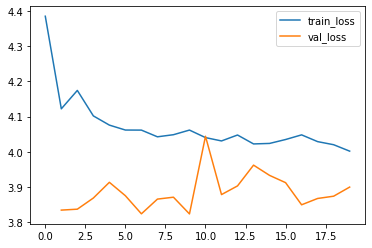

In [93]:
_ = log.plot()

In [94]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

In [104]:
# let's look at the characteristics of those customers that their chances to remain as client are less than 70% in the first year
# we get the same picture as before. Those customers are those that their contract is monthly, they do not have dependent and no other extra services with the company
print(pd.DataFrame.to_markdown(X_test.iloc[(np.array(surv.iloc[surv.index==12,:]<=.7)).T,:].describe() ))

|       |   SeniorCitizen |   MonthlyCharges |   gender_Female |   gender_Male |   Partner_No |   Partner_Yes |   Dependents_No |   Dependents_Yes |   PhoneService_No |   PhoneService_Yes |   MultipleLines_No |   MultipleLines_No phone service |   MultipleLines_Yes |   InternetService_DSL |   InternetService_Fiber optic |   InternetService_No |   OnlineSecurity_No |   OnlineSecurity_No internet service |   OnlineSecurity_Yes |   OnlineBackup_No |   OnlineBackup_No internet service |   OnlineBackup_Yes |   DeviceProtection_No |   DeviceProtection_No internet service |   DeviceProtection_Yes |   TechSupport_No |   TechSupport_No internet service |   TechSupport_Yes |   StreamingTV_No |   StreamingTV_No internet service |   StreamingTV_Yes |   StreamingMovies_No |   StreamingMovies_No internet service |   StreamingMovies_Yes |   Contract_Month-to-month |   Contract_One year |   Contract_Two year |   PaperlessBilling_No |   PaperlessBilling_Yes |   PaymentMethod_Bank transfer (automatic) |